# Question 9: Which player has won the most tournaments in a single month?
---
## **Tournament-wise Most Winner Analysis Attempt**
In this task, I initially aimed to identify the player with the most match wins per tournament using the available data. 
The idea was to associate match winners with their respective tournaments and then perform a grouped count.

To achieve this, I explored multiple columns from the `raw_match_parquet`, `raw_odds_parquet`, and other relevant subfolders. I specifically searched for any columns that would contain tournament IDs, names, or any other fields that could help me group matches by tournament. However, I encountered two main issues:

1. Most of the potentially relevant columns (e.g., tournament ID, event slug, location) were completely filled with NaNs or missing in a large portion of the files.

2. I found no reliable way to link a match to a specific tournament across different files, especially because match metadata was not consistent or comprehensive enough.

Despite testing various fallback approaches (like trying to infer tournaments from file structure or by joining on indirect fields), the quality of the data simply did not allow for an accurate or meaningful grouping by tournament.

⏳ Due to time constraints, I decided to drop this question for now and revisit it later.

## **Alternative: Most Winning Player in February**
As a substitute, I answered a similar question: `Who had the most match wins during one month?`

**To answer this:**

1. I extracted all matches from the February date range (20240201–20240229).
2. I used the `raw_odds_parquet` files to get all match_ids where the winnig flag was True.
3. Then I joined those with `raw_match_parquet` to get the `full_name` of the winning players.



In [4]:
import os
from pathlib import Path
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [6]:
def get_top_winning_player(base_path, start_date=None, end_date=None):
    """
    Find the player with the most match wins within a given date range.
    """
    odds_columns = ['match_id', 'winnig']
    match_columns = ['match_id', 'full_name']

    # Load odds and match data
    o_df = load_all_data_selected_columns(base_path, 'raw_odds_parquet', odds_columns, start_date, end_date)
    matches_df = load_all_data_selected_columns(base_path, 'raw_match_parquet', match_columns, start_date, end_date)

    if o_df is None or matches_df is None:
        print("❌ Failed to load necessary data.")
        return

    # Extract match IDs where winning == True
    winners_df = o_df[o_df['winnig'] == True][['match_id']].dropna()

    # Join with matches to get player names
    merged_df = winners_df.merge(matches_df, on='match_id', how='left')

    if merged_df.empty:
        print("⚠️ No valid match data after merging.")
        return

    # Count full_name frequency
    winner_counts = merged_df['full_name'].value_counts().reset_index()
    winner_counts.columns = ['player_name', 'wins']

    top_winner = winner_counts.iloc[0]
    print(f"🏆 Top player: {top_winner['player_name']} with {top_winner['wins']} wins.")

    return winner_counts

In [10]:
base_path = "../data/tennis_data"
start_date = "20240201"
end_date = "20240229"

winners = get_top_winning_player(base_path, start_date, end_date)

Loading selected columns: 100%|██████████| 10787/10787 [00:17<00:00, 612.49it/s]


✔️ Successfully loaded 10787 files.
⚠️ Skipped 0 files due to missing columns.


Loading selected columns: 100%|██████████| 144823/144823 [03:46<00:00, 638.08it/s]


✔️ Successfully loaded 144823 files.
⚠️ Skipped 0 files due to missing columns.
🏆 Top player: Nagal, Sumit with 204 wins.


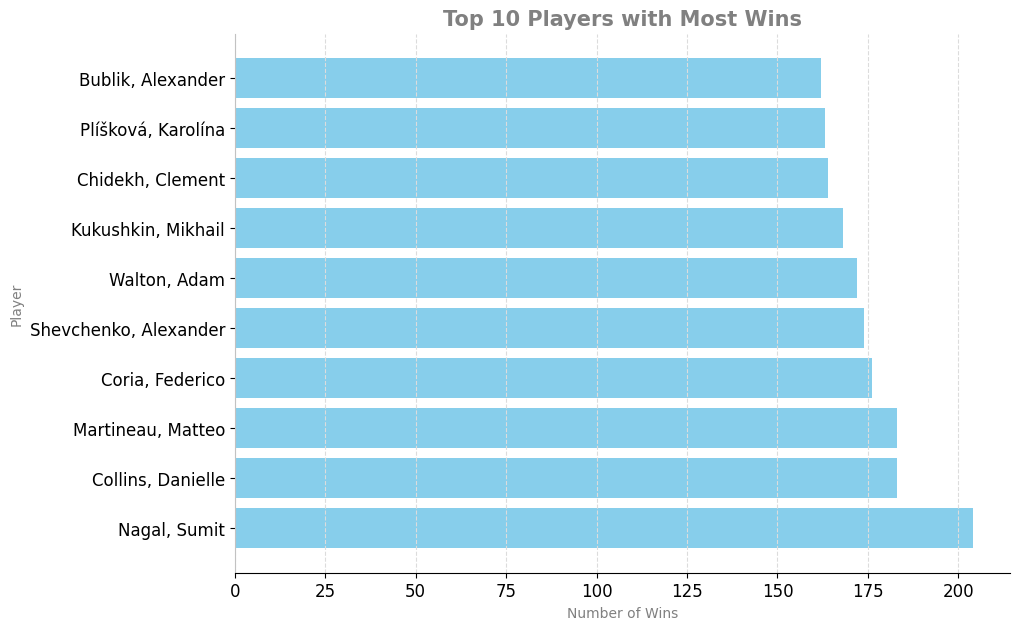

In [13]:
top_players = winners.sort_values(by='wins', ascending=False).head(10)
players = top_players['player_name']
wins = top_players['wins']

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(players, wins, color='skyblue')

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left']].set_color("#c2c2c2")
ax.set_title(f"Top 10 Players with Most Wins", weight="bold", color="grey", fontsize=15)

ax.tick_params(axis="x", labelsize="large")
ax.tick_params(axis="y", labelsize="large")

ax.set_xlabel("Number of Wins", fontsize=10, color="grey")
ax.set_ylabel("Player", fontsize=10, color="grey")

ax.grid(axis="x", linestyle="dashed", color="gainsboro")

plt.savefig("../outputs/figures/mvpInOneMonth.png", dpi=300)
plt.show()